# Chapter 16. Logistic Regression

In [110]:
from __future__ import division
from collections import Counter
from functools import partial  # https://www.pydanny.com/python-partials-are-fun.html
from linear_algebra import dot, vector_add
from gradient_descent import maximize_stochastic, maximize_batch
from working_with_data import rescale
from machine_learning import train_test_split
from multiple_regression import estimate_beta, predict
import math, random
import matplotlib.pyplot as plt
import numpy as np

In Chapter 1, we briefly looked at the problem of trying to predict which DataSciencester users paid for premium accounts.  
Here we'll revisit that problem.

## The Problem

We have an anonymized data set of about 200 users, containing each user's salary, her years of experience as a data scientist, and whether she paid for a premium account.  
As is usual with categorical variables, we represent the dependent variable as either 0 (no premium account) or 1 (premium account).  

In [111]:
data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),(0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),(8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),(2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),(4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),(9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),(2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]

Our data is in a matrix where each row is a list `[experience, salary, paid_account]`.  
Let's turn it into the format that we need:

In [112]:
data = map(list, data)  # change tuples to lists
x = [[1] + row[:2] for row in data]  # each element is [1, experience, salary]
y = [row[2] for row in data]         # each element is paid_account (or not)

Let's make a quick plot of our data to better understand what's going on:

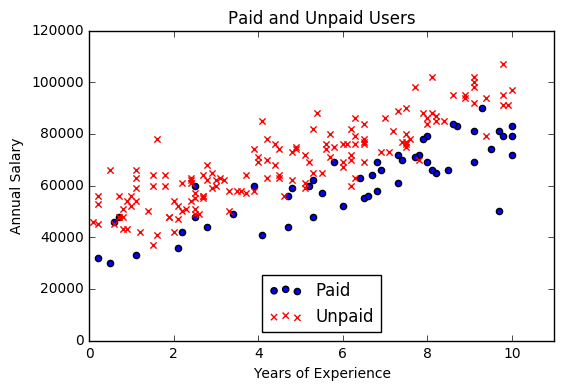

In [113]:
paid = [row for row in data if row[2] == 1]    # paid users
paid_x = [i[0] for i in paid]                  # paid users experience
paid_y = [i[1] for i in paid]                  # paid users salary

unpaid = [row for row in data if row[2] == 0]  # unpaid users
unpaid_x = [i[0] for i in unpaid]              # unpaid users experience
unpaid_y = [i[1] for i in unpaid]              # unpaid users salary

plt.scatter(paid_x, paid_y, marker='o', label="Paid")
plt.scatter(unpaid_x, unpaid_y, c='r', marker='x', label="Unpaid")
plt.axis([0, 11, 0, 120000])
plt.legend(loc=8)
plt.title("Paid and Unpaid Users")
plt.xlabel("Years of Experience")
plt.ylabel("Annual Salary")
plt.show()

An obvious first attempt is to use linear regression to find the best model:  

$\large \text{paid account} = \beta_0 + \beta_1\text{experience} + \beta_2\text{salary} + \epsilon$

In [114]:
rescaled_x = rescale(x)
beta = estimate_beta(rescaled_x, y)
print beta
predictions = [predict(x_i, beta) for x_i in rescaled_x]
predictions

[0.2600919686043904, 0.4386296561514341, -0.4273771266775792]


[0.11238082369782826,
 0.29723737945058676,
 0.059580040889810254,
 0.2389387574302626,
 0.15863083991914823,
 0.42820434773780525,
 0.3897015346100965,
 0.15204419604931985,
 0.3820081474411807,
 0.5822694161733359,
 0.26532121019270644,
 -0.0482529499659656,
 0.6922979549857211,
 0.17403555289854472,
 0.16519954514741136,
 0.19606278703090008,
 0.15532854866345144,
 0.2279430790056501,
 -0.06146211498875265,
 0.4061950522470151,
 0.044193266551978916,
 0.5778424429769866,
 0.024397457659363464,
 0.23783201413117522,
 0.2818864823958859,
 0.6042428343809956,
 -0.07900856000006318,
 0.2092181361289916,
 0.8001130071999316,
 -0.1142449591552055,
 -0.10871124265976895,
 -0.15828148877835085,
 0.15199038012462435,
 0.12778553667722475,
 0.33909629975868777,
 0.17949751482772064,
 0.5766998223947688,
 0.0012993575110512579,
 0.389665657326966,
 0.09701198800156197,
 0.3467896869276036,
 0.2004180056609886,
 0.11238082369782826,
 0.35444719681338893,
 0.4754714140503867,
 0.5085122652489196

Here's a quick plot of the results:

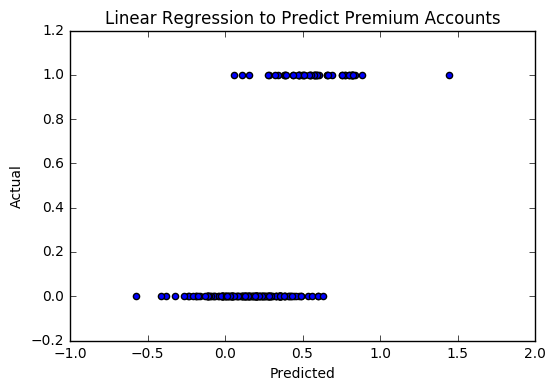

In [115]:
plt.scatter(predictions, y)
plt.title("Linear Regression to Predict Premium Accounts")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

We *could* model the problem this way, but there are a couple of immediate problems:  
- We want our predicted outputs to be 1 or 0, to indicate class membership.  
It's fine if they are between 0 and 1, since we can interpret these as probabilities -- an output of 0.25 means a 25% chance of being a paid member.  
However, the outputs of the linear model can be negative numbers or positive numbers that are greater than 1, which are difficult to interpret.  
In the example above, a lot of the predictions are negative.  
- The linear regression model assumed that the errors were uncorrelated with the columns of $x$.  
In the example above, the regression coefficient for `experience` is 0.44, indicating that more experience leads to a greater likelihood of a premium account.  
This means that our model outputs a very large value for people with lots of experience.  
However, we know that the actual values must be at most 1, which means that very large outputs (and very large values of `experience`) correspond to very large negative values of the error term.  
Therefore, our estimate of `beta` is biased.

What we want instead is for large positive values of dot(x_i, beta) to correspond to probabilities close to 1, and for large negative values to correspond to probabilities close to 0.  
We can accomplish this by applying another function to the result.

## The Logistic Function

In the case of logistic regression, we use the [logistic function](https://en.wikipedia.org/wiki/Logistic_function):

In [116]:
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

To aid in our understanding of the logistic function, let's visualize:

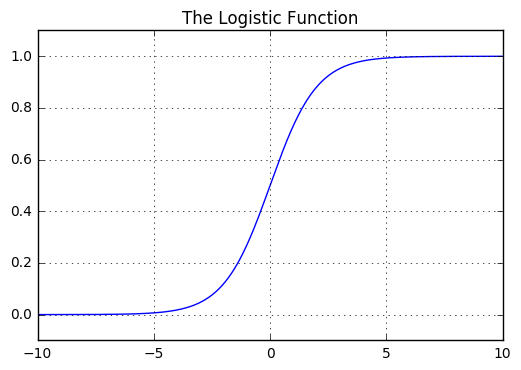

In [117]:
x = np.linspace(-10, 10, 500)  # 500 points between -10 and 10
y = 1.0 / (1 + np.exp(-x))     # logistic function using numpy library
plt.figure()
plt.plot(x, y)
plt.axis([-10, 10, -0.1, 1.1])
plt.title("The Logistic Function")
plt.grid(True)
plt.show()

As the logistic function's input gets large and *positive*, its output gets closer to *1*.  
As the logistic function's input gets large and *negative*, its output gets closer to *0*.  
The logistic function also has the convenient property that its derivative is calculated by:

In [118]:
def logistic_prime(x):
    return logistic(x) * (1 - logistic(x))

And looks like this when plotted:

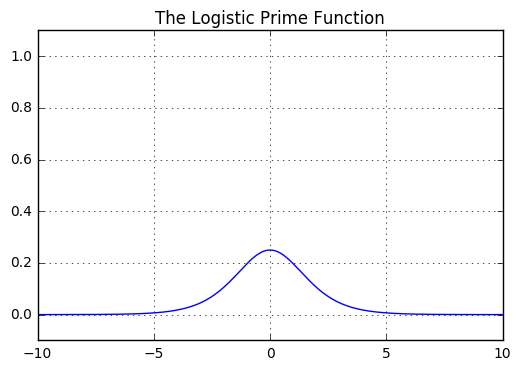

In [119]:
x = np.linspace(-10, 10, 500)  # 500 points between -10 and 10
y_prime = y * (1 - y)          # logistic prime function using y from logistic function
plt.figure()
plt.plot(x, y_prime)
plt.axis([-10, 10, -0.1, 1.1])
plt.title("The Logistic Prime Function")
plt.grid(True)
plt.show()

We'll make use of the `logistic_prime()` function soon when we use it to fit the following model:  

$\Large y_i = f(x_i\beta) + \epsilon_i$

where $f$ is the `logistic()` function.

Recall that for linear regression we fit the model by minimizing the sum of the squared errors, which ended up choosing the $\beta$ that maximized the likelihood of the data.  
Here the two aren't equivalent, so we'll use gradient descent to maximize the likelihood directly.  
This means that we need to calculate the likelihood function and its gradient.  
Given some $\beta$, our model says that each $y_i$ should equal 1 with probability $\normalsize f(x_i\beta)$ and 0 with probability $\normalsize 1 - f(x_i\beta)$.  
In particular, the probability density function for $y_i$ can be written as:  

$\Large p(y_i\;|\;x_i,\;\beta) = f(x_i\beta)^{y_i}(1 - f(x_i\beta))^{1-y_i}$  

since if $y_i$ is 0, this equals:  

$\Large 1 - f(x_i\beta)$  

and if $y_i$ is 1, it equals:  

$\Large f(x_i\beta)$

It turns out that it's actually simpler to maximize the [log likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood):  

$\large \text{log}\;L(\beta\;|\;x_i,\;y_i) = y_i\;\text{log}\;f(x_i\beta) + (1 - y_i)\;\text{log}\;(1 - f(x_i\beta))$  

Because the logarithm is a [monotonically increasing](https://en.wikipedia.org/wiki/Monotonic_function#Monotonically_increasing) function, any `beta` that maximizes the log likelihood also maximizes the likelihood, and vice versa.

In [120]:
def logistic_log_likelihood(x_i, y_i, beta):
    if y_i == 1:
        return math.log(logistic(dot(x_i, beta)))
    else:
        return math.log(1 - logistic(dot(x_i, beta)))

If we assume that different data points are independent from one another, the overall likelihood is just the product of the individual likelihoods.  
This means that the overall log likelihood is the sum of the individual log likelihoods:

In [121]:
def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta) for x_i, y_i in zip(x, y))

A little bit of calculus gives us the gradient:

In [122]:
def logistic_log_partial_ij(x_i, y_i, beta, j):
    """ here i is the index of the data point, j is the index of the derivative """
    return (y_i - logistic(dot(x_i, beta))) * x_i[j]

def logistic_log_gradient_i(x_i, y_i, beta):
    """ the gradient of the log likelihood corresponding to the ith data point """
    return [logistic_log_partial_ij(x_i, y_i, beta, j) for j, _ in enumerate(beta)]

def logistic_log_gradient(x, y, beta):
    return reduce(vector_add, [logistic_log_gradient_i(x_i, y_i, beta) for x_i, y_i in zip(x,y)])

Now we have all of the pieces that we need to apply our model.

## Applying the Model